In [7]:
# Modules for debugging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend


# Custom modules
from preprocessing_post_fastsurfer.alignment import *
from preprocessing_post_fastsurfer.cropping import *
from preprocessing_post_fastsurfer.extraction import *
from preprocessing_post_fastsurfer.file_handling import *
from preprocessing_post_fastsurfer.mesh_creation import *
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *

# Custom modules
from ozzy_torch_utils.split_dataset import *
from ozzy_torch_utils.subject_dataset import *

np.set_printoptions(precision=2, suppress=True)

In [8]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-large-cohort"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the data of interest
data_string = 'hcampus_pointcloud'

# Dictionary key representing the disease labels
labels_string = 'research_group'

# Prevent class imbalance
downsample_majority = True

# NB this argument makes prevent_id_leakage redundant
single_img_per_subject = False

# Prevent the same subject id from occuring in train and test, in case of more than one image per id
prevent_id_leakage = True

test_size = 0.3

In [9]:
dataset = SubjectDataset(data_path, selected_labels, downsample_majority=downsample_majority)

In [10]:

train_data, test_data = split_dataset(dataset, test_size=test_size, prevent_id_leakage=prevent_id_leakage)

volumes_train = [dataset[index]['volumes'] for index in train_data.indices]

volumes_test = [dataset[index]['volumes'] for index in test_data.indices]

labels_train = [dataset[index]['research_group'] for index in train_data.indices]

labels_test = [dataset[index]['research_group'] for index in test_data.indices]

In [11]:
labels = [dataset[index]['research_group'] for index in range(len(dataset.subject_list))]

volumes = [dataset[index]['volumes'] for index in range(len(dataset.subject_list))]

print(f"Unique labels: {np.unique(labels, return_counts=True)}\n")

Unique labels: (array([0, 1]), array([1963, 1963]))



In [24]:

with parallel_backend('threading', n_jobs=8):

    model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=2)

    # Need to implement k fold with non-leakage datasets
    cv = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores = cross_val_score(model, volumes, labels, cv=cv, scoring='accuracy')

    print(f'Cross-validation accuracy scores: {cv_scores}')
    print(f'Mean cross-validation accuracy: {np.mean(cv_scores)}')
    print(f'Standard deviation of cross-validation accuracy: {np.std(cv_scores)}')

Cross-validation accuracy scores: [0.9  0.93 0.9  0.9  0.88 0.9  0.91 0.91 0.89 0.9 ]
Mean cross-validation accuracy: 0.901682505063094
Standard deviation of cross-validation accuracy: 0.012317605431425823


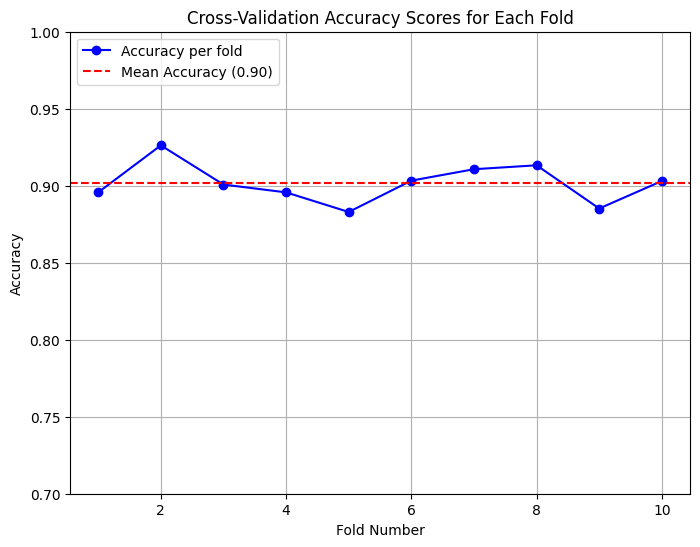

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label='Accuracy per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean Accuracy ({np.mean(cv_scores):.2f})')
plt.title('Cross-Validation Accuracy Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()